In [ ]:
import os
import pandas as pd
import tensorflow
import numpy as np
import transformers
import torch
import pandas as pd
import tensorflow as tf

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

print(transformers.__version__)
print(tf.__version__)



4.51.3
2.18.0


**데이타**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC

/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC


train 데이타와 synonym 증강 데이타 사용한다. validate_data는 별도 read한다

In [ ]:

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')


train_data_path = os.path.join(data_dir, 'raw_csv', 'merged_train_train.csv')
aug_data_path = os.path.join(data_dir,   'aug_csv', 'aug_KoEDA_train_only.csv')
ai_data_path = os.path.join(data_dir,    'raw_csv', 'conversations_aihub.csv')

val_data_path = os.path.join(data_dir,   'raw_csv', 'merged_train_val.csv')



In [ ]:
train_data = pd.read_csv(train_data_path)[["conversation", "class"]]
aug_data = pd.read_csv(aug_data_path)[["conversation", "class"]]
ai_data = pd.read_csv(ai_data_path).iloc[:16158][["conversation", "class"]]
#ai_data = pd.read_csv(ai_data_path).iloc[:2158][["conversation", "class"]]
#ai_data = pd.read_csv(ai_data_path).iloc[:8158][["conversation", "class"]]

val_data = pd.read_csv(val_data_path)[["conversation", "class"]]

print('train 샘플수 :', (len(train_data)))
print('val 샘플수 :', (len(val_data)))
print('aug 샘플수 :', (len(aug_data)))
print('ai 샘플수 :', (len(ai_data)))

train 샘플수 : 3709
val 샘플수 : 928
aug 샘플수 : 6152
ai 샘플수 : 16158


In [ ]:
class_counts = train_data['class'].value_counts()
print('train class :\n', class_counts)

class_counts = val_data['class'].value_counts()
print('val class :\n', class_counts)

class_counts = aug_data['class'].value_counts()
print('aug class :\n', class_counts)

train class :
 class
기타 괴롭힘 대화      809
갈취 대화          778
직장 내 괴롭힘 대화    776
협박 대화          713
일반 대화          633
Name: count, dtype: int64
val class :
 class
기타 괴롭힘 대화      202
갈취 대화          195
직장 내 괴롭힘 대화    194
협박 대화          179
일반 대화          158
Name: count, dtype: int64
aug class :
 class
기타 괴롭힘 대화      1618
갈취 대화          1556
직장 내 괴롭힘 대화    1552
협박 대화          1426
Name: count, dtype: int64


In [ ]:
# 일반대화는 ai_data로 사용
train_data = train_data[train_data['class'] != '일반 대화']

val_data = val_data[val_data['class'] != '일반 대화'] #158개
val_data = pd.concat([val_data, ai_data.tail(158)], ignore_index=True) # 일반 대화에서 뒤에서 158개로 대체하여 기존 검증 샘플 수(928) 유지
ai_data = ai_data.iloc[:-158] # 대체한 만큼 원본도 잘라주기

# train_data merge
df_combined = pd.concat([train_data, aug_data, ai_data], ignore_index=True)

#셔플
shuffled_df = df_combined.sample(frac=1).reset_index(drop=True)

# class count
class_counts = shuffled_df['class'].value_counts()
print('train class :\n', class_counts)

class_counts = val_data['class'].value_counts()
print('val class :\n', class_counts)

train class :
 class
일반 대화          16000
기타 괴롭힘 대화       2427
갈취 대화           2334
직장 내 괴롭힘 대화     2328
협박 대화           2139
Name: count, dtype: int64
val class :
 class
기타 괴롭힘 대화      202
갈취 대화          195
직장 내 괴롭힘 대화    194
협박 대화          179
일반 대화          158
Name: count, dtype: int64


데이터 전처리

In [ ]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = sentence.replace('\n', ' ').replace('\r', ' ')
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [ ]:
shuffled_df["conversation"] = [preprocess_sentence(s) for s in shuffled_df["conversation"]]
val_data["conversation"] = [preprocess_sentence(s) for s in val_data["conversation"]]

train_data = shuffled_df

shuffled_df.head()

,conversation,class
0,우리 애 성적이 안오르는 이유가 뭘까 ? 어떻게 공부하고 있어 ? 국영수 위주로 하...,일반 대화
1,오늘 대형사고 쳤다 퇴사를 해야할지 고민이된다 얼마나 큰 사고길래 퇴사까지요 몰라 ...,일반 대화
2,스쿠버다이빙 배우고 싶은데 어려울까요 ? 저는 무서워서 엄두 못 내요 . 전 수영을...,일반 대화
3,아들 엄마 철원 다녀오려고 갑자기 무슨 철원이에요 ? 한탄강이 아주 멋지다더라 한탄...,일반 대화
4,어 ! 저새끼 뭐야 거기 일로와바 너 어디서 부터 봤어 아하나도 못봤어요 야 저기 ...,협박 대화


In [ ]:
# 한 문장의 길이를  num_tokens에 저장
num_tokens = [len(tokens) for tokens in train_data['conversation']]
# array로 변환
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

maxlen = 300
print('train_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

sequences_maxlen = maxlen




문장길이 평균 :  283.0439590930712
문장길이 최대 :  1866
문장길이 표준편차 :  135.62681386914292
train_sequences maxlen :  300
전체 문장의 0.9638893293166323%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
# 클래스 라벨을 숫자로 변환
# 0, 1, 2, 3, 4
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']


class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx



train_data['label'] = train_data['class'].apply(lambda s: class_dict[s])
val_data['label'] = val_data['class'].apply(lambda s: class_dict[s])


train_data.head()

,conversation,class,label
0,우리 애 성적이 안오르는 이유가 뭘까 ? 어떻게 공부하고 있어 ? 국영수 위주로 하...,일반 대화,4
1,오늘 대형사고 쳤다 퇴사를 해야할지 고민이된다 얼마나 큰 사고길래 퇴사까지요 몰라 ...,일반 대화,4
2,스쿠버다이빙 배우고 싶은데 어려울까요 ? 저는 무서워서 엄두 못 내요 . 전 수영을...,일반 대화,4
3,아들 엄마 철원 다녀오려고 갑자기 무슨 철원이에요 ? 한탄강이 아주 멋지다더라 한탄...,일반 대화,4
4,어 ! 저새끼 뭐야 거기 일로와바 너 어디서 부터 봤어 아하나도 못봤어요 야 저기 ...,협박 대화,0


**test data**

In [ ]:

test_data_path = os.path.join(data_dir, 'raw_csv', 'test.csv')


test_data = pd.read_csv(test_data_path)
test_data.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [ ]:
# 한 문장의 길이를  num_tokens에 저장
num_tokens = [len(tokens) for tokens in test_data['text']]
# array로 변환
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('test_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

test_maxlen = maxlen

문장길이 평균 :  213.626
문장길이 최대 :  722
문장길이 표준편차 :  101.13918194250931
test_sequences maxlen :  466
전체 문장의 0.972%가 maxlen 설정값 이내에 포함됩니다. 


훈련/검증 데이터셋 분리
- validation set은 original_train_set으로 부터 생성하도록 고정
- random_state=42

In [ ]:
# train set
train_texts = train_data['conversation'].tolist()
train_labels = train_data['label'].tolist()

# validation set
val_texts = val_data['conversation'].tolist()
val_labels = val_data['label'].tolist()


**beomi/kcbert-base**

In [ ]:
from transformers import TFBertForSequenceClassification

model_name = "beomi/kcbert-base"

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained(model_name)

#PyTorch로 학습된 beomi/kcbert-base 모델을 TensorFlow로 변환하여 사용
from transformers import TFBertModel

model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=len(class_dict),  from_pt=True)#  클래스 수에 맞게

# tokenizer의 vocab 사이즈 확인
tokenizer.vocab_size


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


30000

In [ ]:
# TensorFlow 데이터셋으로 변환
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=sequences_maxlen)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=sequences_maxlen)

# TensorFlow 데이터셋으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# 배치 처리 및 셔플
train_dataset = train_dataset.shuffle(1000).batch(16)
val_dataset = val_dataset.shuffle(1000).batch(16)

In [ ]:
from transformers import AutoConfig


config = AutoConfig.from_pretrained(model_name)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 300,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

In [ ]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])



In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108918528 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108922373 (415.51 MB)
Trainable params: 108922373 (415.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger
wandb.login()

# W&B 프로젝트 초기화
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="jiwoong-team",
    # Set the wandb project where this run will be logged.
    project="DLThon-DKTC",
    # Track hyperparameters and run metadata.
    name=f"moya_KcBert_ai16000", # 실험 이름
    notes="ai16000 데이터를 사용한 기준선 실험", # 실험에 대한 간단한 설명
    config={ # 세부 구성 내용
        "experiment_name": "kcbert",
        "general_conversation_type": "kakao 일반데이타", # 일반 데이터 타입
        "architecture": "kcbert-base)",
    },
)



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moya9292 (jiwoong-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# 모델 학습
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1
    #callbacks=[WandbMetricsLogger()]  # WandbMetricsLogger를 콜백으로 넘겨주기만 하면 알아서 epoch별 metric을 기록
)

1577/1577 [==============================] - 1685s 1s/step - loss: 0.1586 - accuracy: 0.9470 - val_loss: 0.3369 - val_accuracy: 0.9019


In [ ]:
from sklearn.metrics import classification_report
# 최적의 모델로 검증세트 예측


# 예측 수행
logits = model.predict(val_dataset).logits
# 소프트맥스 후 argmax로 클래스 인덱스 추출
y_pred_labels = np.argmax(logits, axis=-1)


# val_dataset에서 정답 라벨만 추출
y_true_labels = []

for batch in val_dataset:
    _, labels = batch  # unpack (inputs, labels)
    y_true_labels.extend(labels.numpy())

y_true_labels = np.array(y_true_labels)


# wandb Table 생성
report = classification_report(y_true_labels, y_pred_labels, target_names=CLASS_NAMES, output_dict=True)
columns = ["class", "precision", "recall", "f1-score", "support"]
data = []

for label, metrics in report.items():
    if isinstance(metrics, dict):  # dict일 때만 values 가져오기
        row = [label] + [metrics.get(col, None) for col in columns[1:]]
        data.append(row)

table = wandb.Table(columns=columns, data=data)

# wandb에 훈련 결과 기록
wandb.log({
    "classification_report_table": table,
    "macro_f1": report["macro avg"]["f1-score"],
    "accuracy": report["accuracy"],
    "threat_f1": report["협박 대화"]["f1-score"],
    "extortion_f1": report["갈취 대화"]["f1-score"],
    "workplace_bullying_f1": report["직장 내 괴롭힘 대화"]["f1-score"],
    "other bullying": report["기타 괴롭힘 대화"]["f1-score"],
    "general_conversation_f1": report["일반 대화"]["f1-score"],
})

# 실험 종료
run.finish()

58/58 [==============================] - 24s 360ms/step


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other bullying,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.19504
extortion_f1,0.22281
general_conversation_f1,0.1548
macro_f1,0.19403


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

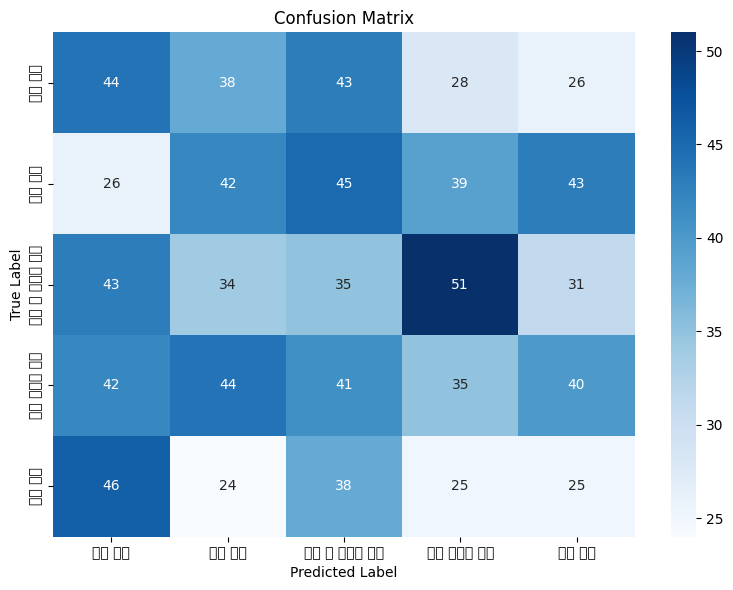

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix 생성
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=range(len(CLASS_NAMES)))

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=CLASS_NAMES, output_dict=False)
report

'              precision    recall  f1-score   support\n\n       협박 대화       0.22      0.25      0.23       179\n       갈취 대화       0.23      0.22      0.22       195\n 직장 내 괴롭힘 대화       0.17      0.18      0.18       194\n   기타 괴롭힘 대화       0.20      0.17      0.18       202\n       일반 대화       0.15      0.16      0.15       158\n\n    accuracy                           0.20       928\n   macro avg       0.19      0.19      0.19       928\nweighted avg       0.20      0.20      0.19       928\n'

Test 데이타 예측

In [ ]:

def predict_labels(model, tokenizer, texts, max_length=128, batch_size=16):
    """
    주어진 텍스트 리스트에 대해 예측된 클래스 인덱스를 반환하는 함수.

    Args:
        model: 학습된 TensorFlow 모델
        tokenizer: Hugging Face tokenizer
        texts (List[str]): 예측할 텍스트 목록
        max_length (int): 입력 시퀀스 최대 길이
        batch_size (int): 배치 사이즈

    Returns:
        np.ndarray: 예측된 클래스 인덱스 배열
    """
    # 텍스트 인코딩
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

    # TensorFlow Dataset 생성
    dataset = tf.data.Dataset.from_tensor_slices(dict(encodings)).batch(batch_size)

    # 예측 수행
    logits = model.predict(dataset).logits

    # 소프트맥스 후 argmax로 클래스 인덱스 추출
    predictions = np.argmax(logits, axis=-1)

    return predictions


In [ ]:
# 예측
test_texts = test_data["text"].tolist()
predictions = predict_labels(model, tokenizer, test_texts, max_length=sequences_maxlen)
print(predictions)

32/32 [==============================] - 15s 353ms/step
[1 2 2 4 3 0 0 1 4 1 0 4 2 2 2 0 4 3 0 3 0 3 3 1 4 2 3 4 2 4 1 0 4 1 3 1 3
 0 0 1 0 1 2 1 4 2 0 3 4 0 1 3 1 2 2 3 3 4 4 3 1 3 0 3 2 0 4 3 4 1 4 2 3 2
 0 4 2 1 2 4 1 0 4 1 4 2 0 4 1 2 0 2 0 4 3 2 3 2 0 2 3 1 2 0 3 2 2 3 4 0 4
 0 0 2 1 1 4 2 2 1 2 2 1 1 1 1 2 4 1 3 3 3 2 3 1 0 3 0 3 4 0 4 1 3 2 0 0 0
 0 1 0 3 4 1 2 3 0 2 3 3 0 3 4 0 2 3 2 4 3 1 0 2 2 3 2 3 2 2 1 1 2 3 2 2 3
 3 2 0 1 0 0 3 1 3 1 3 3 4 0 3 2 0 3 3 0 3 2 0 2 2 4 3 3 2 1 4 4 4 0 0 1 2
 0 4 0 4 2 0 1 0 2 0 3 3 1 3 3 1 0 3 3 3 3 2 4 1 2 1 2 0 0 2 0 2 2 1 4 2 1
 2 1 2 0 3 2 4 3 4 4 3 0 4 0 2 4 2 2 3 2 2 1 0 0 2 4 2 1 2 0 3 1 1 3 3 2 0
 4 3 1 0 4 3 0 2 1 1 3 2 3 2 2 1 2 4 2 3 0 3 3 0 2 0 0 1 1 1 1 4 2 3 1 0 0
 3 1 4 3 1 4 3 0 2 0 0 1 2 4 1 0 0 0 3 1 1 1 2 3 3 3 4 3 0 1 1 2 4 3 2 3 1
 2 2 0 2 2 3 1 3 1 2 2 0 2 2 3 1 3 0 0 3 1 0 1 2 1 3 0 4 0 0 3 3 2 2 3 3 2
 4 2 1 3 3 0 2 2 4 3 4 1 0 0 0 0 3 3 1 1 2 2 0 3 4 0 0 1 3 0 4 3 2 3 0 2 3
 1 2 0 2 2 4 4 0 2 3 4 1 2 2 1 1 4 1 2 2 2 1

In [ ]:
# 예시: id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': test_data['idx'],
    'class': predictions
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('submission_kcbert_ai16000.csv', index=False)

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,4
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,2


from matplotlib import pyplot as plt
submission_df['class'].plot(kind='hist', bins=20, title='class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission_df['class'].plot(kind='line', figsize=(8, 4), title='class')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# class count
class_counts = submission_df['class'].value_counts()
print('prediction class :\n', class_counts)

prediction class :
 class
2    122
3    110
0    102
1     95
4     71
Name: count, dtype: int64
